# Mohamaco — Weekly Analysis

This notebook analyzes store performance based on `model_data.json` and produces:
- KPI dashboard (with correctly aggregated staff cost)
- Per-product overview table (with profit coloring, HTML + PNG export)
- Weekly Sold % heatmap (annotated)
- Sales Heatmap by Day (annotated) — uses preloaded `transactions` and `products` DataFrames

**Note:** For the daily sales heatmap, make sure both  
`transactions` (`version`, `product`, `day`, `qty`) and  
`products` (`version`, `product`, `amount`) are available in memory  
(or loaded from JSON before running this section).

In [7]:
# === Setup & Load ============================================================
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

MODEL_DATA = Path("model_data.json")
assert MODEL_DATA.exists(), "model_data.json not found. Run the generator first."

md = pd.DataFrame(json.load(open(MODEL_DATA, "r", encoding="utf-8")))
VERSIONS = sorted(md["version"].unique())
V_NOW  = VERSIONS[-1]
V_PREV = VERSIONS[-2] if len(VERSIONS) > 1 else VERSIONS[-1]

print("Versions:", VERSIONS, "| Compare:", V_PREV, "→", V_NOW)
display(md.head(3))

# ---------------------------------------------------------------------------
# Base directories
DATA_DIR = Path("data")
AMOUNTS_DIR = DATA_DIR / "amounts"
PRICES_DIR = DATA_DIR / "prices"
TRANSACTIONS_DIR = DATA_DIR / "transactions"
SCHEDULES_DIR = DATA_DIR / "schedules"
WORKERS_DIR = DATA_DIR / "workers"
SUPPLIER_PATH = DATA_DIR / "supplier_prices.json"

# --- Discover available versions --------------------------------------------
def det_versions():
    """Scan data folders and extract available version numbers (..._X.json)."""
    vs = set()
    for p in [AMOUNTS_DIR, PRICES_DIR, TRANSACTIONS_DIR, SCHEDULES_DIR]:
        if not p.exists():
            continue
        for f in p.glob("*_[0-9].json"):
            try:
                v = int(f.stem.split("_")[-1])
                vs.add(v)
            except Exception:
                pass
    return sorted(vs)

VERSIONS = det_versions()
print("Detected versions:", VERSIONS)
if not VERSIONS:
    raise RuntimeError("No versions found under data/{amounts,prices,transactions,schedules}.")

# --- Helpers -----------------------------------------------------------------
def read_json(path: Path):
    """Read a JSON file and return the parsed data."""
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def load_version_tables(v: int) -> pd.DataFrame:
    """Load amounts and prices for version v and outer-merge them."""
    a = read_json(AMOUNTS_DIR / f"amounts_{v}.json")
    p = read_json(PRICES_DIR / f"prices_{v}.json")
    amounts = pd.DataFrame(list(a.items()), columns=["product","amount"])
    prices  = pd.DataFrame(list(p.items()), columns=["product","price"])
    return amounts.merge(prices, on="product", how="outer").assign(version=v)

def load_transactions(v: int) -> pd.DataFrame:
    """Explode transactions_v.json into row-wise records, including day and customer."""
    raw = read_json(TRANSACTIONS_DIR / f"transactions_{v}.json")
    rows = []
    for day, txs in raw.items():  # <-- day key from 1 to 7
        for tx in txs:
            types, amts = tx.get("merch_types", []), tx.get("merch_amounts", [])
            for t, a in zip(types, amts):
                rows.append({
                    "product": str(t),
                    "qty": float(a),
                    "version": v,
                    "day": int(day),               # <-- include day
                    "worker": tx.get("register_worker"),
                    "customer_id": tx.get("customer_id")  # <-- include buyer id
                })
    return pd.DataFrame(rows)


# --- Core tables -------------------------------------------------------------
supplier = pd.DataFrame(list(read_json(SUPPLIER_PATH).items()), columns=["product","supplier_price"])

products = pd.concat([load_version_tables(v) for v in VERSIONS], ignore_index=True)
transactions = pd.concat(
    [load_transactions(v) for v in VERSIONS if (TRANSACTIONS_DIR / f"transactions_{v}.json").exists()],
    ignore_index=True
)

# Merge to build analysis frame: products ⟶ aggregated transactions ⟶ supplier prices
df = (products
      .merge(transactions.groupby(["version","product"])["qty"].sum().reset_index(),
             on=["version","product"], how="left")
      .merge(supplier, on="product", how="left"))

# Costs on sold-basis (COGS) — for per-unit margins
md["cogs_sold"] = md["qty"] * md["supplier_price"]

# Procurement costs for the week (for weekly P&L)
md["procurement_cost"] = md["amount"] * md["supplier_price"]

# Revenues / gross profits by perspective
md["revenue"] = md["qty"] * md["price"]
md["gross_profit_sold"] = md["revenue"] - md["cogs_sold"]
md["gross_profit_proc"] = md["revenue"] - md["procurement_cost"]

print("Data merged.")
display(df.head(3))

# === Add Salvage (25%) ======================================================
SALVAGE_RATE = 0.25

# Robustly ensure required columns exist
for col in ["amount", "qty", "supplier_price", "price"]:
    if col not in md.columns:
        md[col] = 0.0

md["amount"] = pd.to_numeric(md["amount"], errors="coerce").fillna(0.0)
md["qty"]    = pd.to_numeric(md["qty"], errors="coerce").fillna(0.0)
md["supplier_price"] = pd.to_numeric(md["supplier_price"], errors="coerce").fillna(0.0)
md["price"]  = pd.to_numeric(md["price"], errors="coerce").fillna(0.0)

# Leftovers & salvage (computed; if model_data.json already has salvage_value,
# we only overwrite missing values)
md["leftover"] = (md["amount"] - md["qty"]).clip(lower=0.0)

if "salvage_value" not in md.columns or md["salvage_value"].isna().all():
    md["salvage_value"] = md["leftover"] * md["supplier_price"] * SALVAGE_RATE
else:
    # Cast existing salvage_value to numeric and fill missing with calculated salvage
    md["salvage_value"] = pd.to_numeric(md["salvage_value"], errors="coerce").fillna(
        md["leftover"] * md["supplier_price"] * SALVAGE_RATE
    )

# Quick check: salvage totals per version
salvage_check = (
    md.groupby("version")[["leftover","salvage_value"]]
      .sum()
      .reset_index()
      .rename(columns={"leftover":"leftover_units"})
)
print("\nSalvage overview per version:")
display(salvage_check)

Versions: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)] | Compare: 6 → 7


,product,amount,price,version,qty,supplier_price,revenue,product_cost,gross_profit,sell_through,...,D_out_est,TAST_norm,version_staff_cost,profit_per_worker,legacy_product_cost,legacy_gross_profit,sales_revenue,salvage_rate,salvage_value,net_profit
0,batteries,2096,15.85,0,2096.0,12.0,33221.60,25152.0,8069.60,1.0,...,3.0,1.0,194596.337915,0.041468,25152.0,8069.60,33221.60,0.25,0.00,-186526.737915
1,dinosaur,1947,94.60,0,0.0,65.0,0.00,126555.0,-94916.25,0.0,...,8.0,0.0,194596.337915,0.000000,0.0,0.00,0.00,0.25,31638.75,-289512.587915
2,gjokur_ja,69,814.31,0,69.0,580.0,56187.39,40020.0,16167.39,1.0,...,3.0,1.0,194596.337915,0.083082,40020.0,16167.39,56187.39,0.25,0.00,-178428.947915


Detected versions: [0, 1, 2, 3, 4, 5, 6, 7]
Data merged.


,product,amount,price,version,qty,supplier_price
0,batteries,2096,15.85,0,2096.0,12.0
1,dinosaur,1947,94.60,0,NaN,65.0
2,gjokur_ja,69,814.31,0,69.0,580.0



Salvage overview per version:


,version,leftover_units,salvage_value
0,0,7603.0,171993.75
1,1,8749.0,302049.50
2,2,9452.0,360075.00
3,3,9677.0,357331.75
4,4,3106.0,198290.00
5,5,2092.0,103356.25
6,6,3372.0,132725.00
7,7,2328.0,51443.50


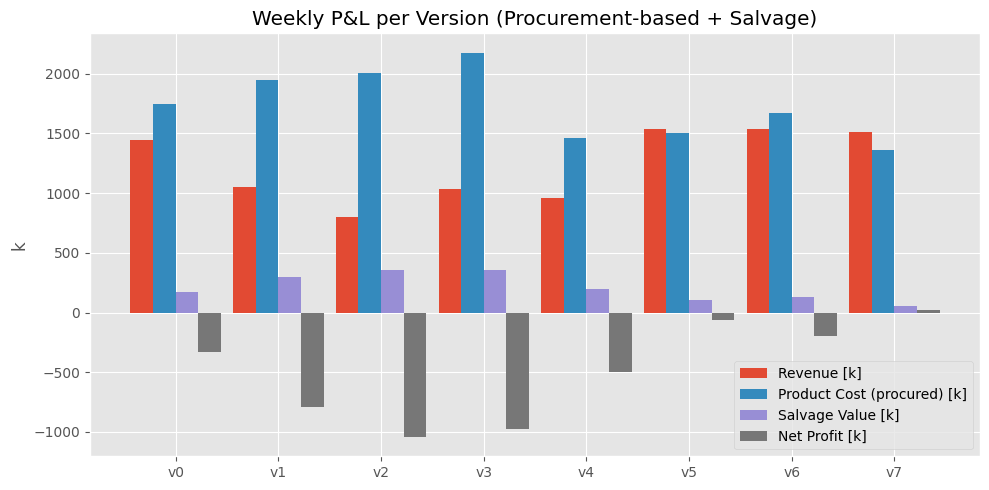

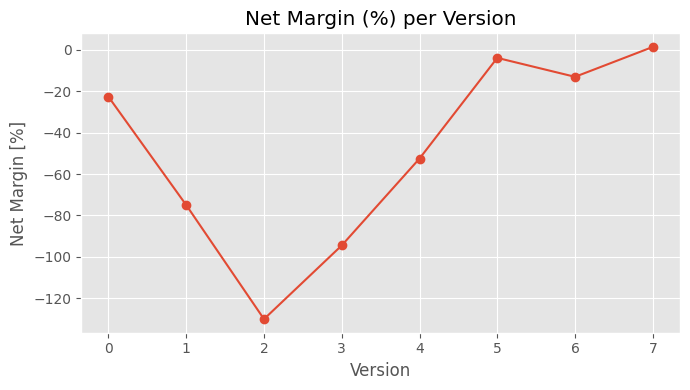


P&L summary (incl. salvage):


,version,revenue,procurement_cost,salvage_value,staff_cost,net_profit,net_margin_%
0,0,1444527.59,1749309.0,171993.75,194596.337915,-3.273840e+05,-22.663741
1,1,1053705.70,1951435.0,302049.50,194596.337915,-7.902761e+05,-74.999702
2,2,801424.92,2009582.0,360075.00,194596.337915,-1.042678e+06,-130.103069
3,3,1036064.91,2177713.0,357331.75,194596.337915,-9.789127e+05,-94.483721
4,4,956008.62,1461647.0,198290.00,194596.337915,-5.019447e+05,-52.504204
5,5,1533697.87,1501533.0,103356.25,194596.337915,-5.907522e+04,-3.851816
6,6,1534150.17,1671833.0,132725.00,194596.337915,-1.995542e+05,-13.007473
7,7,1514835.58,1362563.0,51443.50,181976.142999,2.173994e+04,1.435135


In [8]:
# === KPI Dashboard (staff correct, salvage explicit) =========================
# Core totals (revenue, COGS on sold units, procurement cost, salvage value)
sum_core = (
    md.groupby("version")[["revenue", "cogs_sold", "procurement_cost", "salvage_value"]]
      .sum()
      .reset_index()
)

# Staff cost: exactly once per version (robust even if column is missing)
if "version_staff_cost" in md.columns:
    staff_once = (
        md.groupby("version")["version_staff_cost"]
          .max()  # one value per version
          .rename("staff_cost")
          .reset_index()
    )
else:
    # If not present, default staff cost to 0.0
    staff_once = pd.DataFrame({"version": sum_core["version"], "staff_cost": 0.0})

# Merge staff into core summary
sumv = sum_core.merge(staff_once, on="version", how="left").fillna(0.0)

# Net Profit (procurement-based + salvage):
#   = revenue + salvage_value - procurement_cost - staff_cost
sumv["net_profit"]   = sumv["revenue"] + sumv["salvage_value"] - sumv["procurement_cost"] - sumv["staff_cost"]
sumv["net_margin_%"] = 100 * np.where(sumv["revenue"] > 0, sumv["net_profit"] / sumv["revenue"], np.nan)

# === KPI Plots ===============================================================
# Bar chart: revenue, procurement cost, salvage value, net profit per version
x = np.arange(len(sumv))
w = 0.22

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - 1.5*w, sumv["revenue"]/1000,          w, label="Revenue [k]")
ax.bar(x - 0.5*w, sumv["procurement_cost"]/1000, w, label="Product Cost (procured) [k]")
ax.bar(x + 0.5*w, sumv["salvage_value"]/1000,    w, label="Salvage Value [k]")
ax.bar(x + 1.5*w, sumv["net_profit"]/1000,       w, label="Net Profit [k]")

ax.set_xticks(x)
ax.set_xticklabels([f"v{i}" for i in sumv["version"]])
ax.set_ylabel("k")
ax.set_title("Weekly P&L per Version (Procurement-based + Salvage)")
ax.legend()
plt.tight_layout()
plt.show()

# Line chart: net margin (%) per version
plt.figure(figsize=(7, 4))
plt.plot(sumv["version"], sumv["net_margin_%"], marker="o")
plt.title("Net Margin (%) per Version")
plt.xlabel("Version")
plt.ylabel("Net Margin [%]")
plt.tight_layout()
plt.show()

# Optional: show summarized P&L table
print("\nP&L summary (incl. salvage):")
display(sumv[["version", "revenue", "procurement_cost", "salvage_value", "staff_cost", "net_profit", "net_margin_%"]])

In [9]:
# === Overview Table (diverging red↔green) + Export [with Salvage] ============
# Build a styled overview table for a chosen version with diverging colors and export to HTML/PNG.

V_SHOW = V_NOW  # change if needed, e.g., 5
SALVAGE_RATE = 0.25
COLOR_BY_SALVAGE = True  # False => color by Real_Profit (without salvage)

# Aggregate product-level view for the selected version
cur = (md[md["version"] == V_SHOW]
       .groupby("product", as_index=False)
       .agg(Amount=("amount", "sum"),
            Sold_Amount=("qty", "sum"),
            Price=("price", "mean"),
            Supplier_Price=("supplier_price", "mean")))

# Base costs/returns
cur["Total_Purchase_Cost"] = cur["Supplier_Price"] * cur["Amount"]     # full procurement for the week
cur["Revenue"]             = cur["Price"] * cur["Sold_Amount"]         # actual revenue
cur["Real_Profit"]         = cur["Revenue"] - cur["Total_Purchase_Cost"]

# Add salvage economics
cur["Leftover"]            = (cur["Amount"] - cur["Sold_Amount"]).clip(lower=0)
cur["Salvage_Value"]       = cur["Leftover"] * cur["Supplier_Price"] * SALVAGE_RATE
cur["Net_Profit_Salvage"]  = cur["Revenue"] + cur["Salvage_Value"] - cur["Total_Purchase_Cost"]

# Sort by salvage-aware profit (highest first)
cur = cur.sort_values("Net_Profit_Salvage", ascending=False).reset_index(drop=True)

# --- Color helpers (diverging red↔green around 0) ---------------------------
def _hex_to_rgb(h):
    """Convert hex color (#rrggbb) to an (r,g,b) tuple."""
    h = h.lstrip("#")
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def _rgb_to_hex(rgb):
    """Convert (r,g,b) tuple to hex color string."""
    return "#{:02x}{:02x}{:02x}".format(*[max(0, min(255, int(round(x)))) for x in rgb])

def _interp(c1, c2, t):
    """Linear interpolate between two hex colors c1→c2 at t∈[0,1]."""
    a = _hex_to_rgb(c1); b = _hex_to_rgb(c2)
    return _rgb_to_hex(tuple(a[i] + (b[i] - a[i]) * t for i in range(3)))

# Define palette endpoints
RED_LIGHT, RED_DARK = "#fde0e0", "#a10000"
GRN_LIGHT, GRN_DARK = "#e7f6e7", "#1b7a1b"
NEUTRAL             = "#ffffff"

def _diverging_color_list(vals: pd.Series):
    """Map a numeric Series to background colors (green for positive, red for negative)."""
    pos_vals = vals[vals > 0]
    neg_vals = -vals[vals < 0]
    pos_max  = float(pos_vals.max()) if not pos_vals.empty else 1.0
    neg_max  = float(neg_vals.max()) if not neg_vals.empty else 1.0

    def color_one(v):
        if v > 0:
            t = 0.0 if pos_max <= 0 else min(1.0, v / pos_max)
            return _interp(GRN_LIGHT, GRN_DARK, t)
        elif v < 0:
            t = 0.0 if neg_max <= 0 else min(1.0, (-v) / neg_max)
            return _interp(RED_LIGHT, RED_DARK, t)
        else:
            return NEUTRAL

    return [f"background-color: {color_one(v)}" for v in vals]

# Which column should be colorized?
COLOR_COL = "Net_Profit_Salvage" if COLOR_BY_SALVAGE else "Real_Profit"

# --- Styler ---------------------------------------------------------------
styled = (cur.style
          .format({
              "Amount": "{:,.0f}",
              "Sold_Amount": "{:,.0f}",
              "Leftover": "{:,.0f}",
              "Price": "{:.2f}",
              "Supplier_Price": "{:.2f}",
              "Total_Purchase_Cost": "{:,.2f}",
              "Revenue": "{:,.2f}",
              "Salvage_Value": "{:,.2f}",
              "Real_Profit": "{:,.2f}",
              "Net_Profit_Salvage": "{:,.2f}",
          })
          .apply(_diverging_color_list, subset=[COLOR_COL])
         )

display(styled)

# --- Export (HTML always, PNG robust) ---------------------------------------
OUT_DIR = Path("output"); OUT_DIR.mkdir(parents=True, exist_ok=True)
html_path = OUT_DIR / f"overview_v{V_SHOW}.html"
with open(html_path, "w", encoding="utf-8") as f:
    f.write(styled.to_html())
print("Saved HTML table:", html_path)

# PNG export: try dataframe_image; fallback to Matplotlib if not available
png_path = OUT_DIR / f"overview_v{V_SHOW}.png"

def _format_df_for_png(df: pd.DataFrame) -> pd.DataFrame:
    """Return a copy of df with preformatted strings (to mirror Styler output)."""
    df2 = df.copy()
    df2["Amount"]               = df2["Amount"].map("{:,.0f}".format)
    df2["Sold_Amount"]          = df2["Sold_Amount"].map("{:,.0f}".format)
    df2["Leftover"]             = df2["Leftover"].map("{:,.0f}".format)
    df2["Price"]                = df2["Price"].map("{:.2f}".format)
    df2["Supplier_Price"]       = df2["Supplier_Price"].map("{:.2f}".format)
    df2["Total_Purchase_Cost"]  = df2["Total_Purchase_Cost"].map("{:.2f}".format)
    df2["Revenue"]              = df2["Revenue"].map("{:.2f}".format)
    df2["Salvage_Value"]        = df2["Salvage_Value"].map("{:.2f}".format)
    df2["Real_Profit"]          = df2["Real_Profit"].map("{:.2f}".format)
    df2["Net_Profit_Salvage"]   = df2["Net_Profit_Salvage"].map("{:.2f}".format)
    return df2

# Precompute exact colors for PNG fallback (to match Styler)
profit_colors = _diverging_color_list(cur[COLOR_COL])
profit_colors_hex = [c.split(": ")[1] for c in profit_colors]  # extract "#xxxxxx"

try:
    import dataframe_image as dfi
    dfi.export(styled, str(png_path), table_conversion="matplotlib", fontsize=10, dpi=300)
    print("Saved PNG via dataframe_image (matplotlib):", png_path)
except Exception as e:
    # Fallback: draw styled table directly with Matplotlib if dataframe_image fails
    print("dataframe_image failed, fallback to pure Matplotlib…", e)
    from matplotlib import colors as mcolors
    df_fmt = _format_df_for_png(cur)
    cols   = list(df_fmt.columns)
    values = df_fmt.values.tolist()

    n_rows, n_cols = len(df_fmt), len(cols)
    fig_w = min(18, 1.2 * n_cols + 4)
    fig_h = max(3.0, 0.42 * n_rows + 1.8)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis("off")
    tbl = ax.table(cellText=values, colLabels=cols, cellLoc="center", loc="center")
    tbl.auto_set_font_size(False); tbl.set_fontsize(9); tbl.scale(1.0, 1.18)

    # Header style
    for (r, c), cell in tbl.get_celld().items():
        if r == 0:
            cell.set_text_props(weight="bold", color="black")
            cell.set_facecolor("#f2f2f2")

    # Apply diverging shades to the chosen profit column
    tp_idx = cols.index("Net_Profit_Salvage" if COLOR_BY_SALVAGE else "Real_Profit")
    for i in range(n_rows):
        tbl[i+1, tp_idx].set_facecolor(profit_colors_hex[i])

    plt.tight_layout()
    fig.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print("Saved PNG via pure Matplotlib:", png_path)

,product,Amount,Sold_Amount,Price,Supplier_Price,Total_Purchase_Cost,Revenue,Real_Profit,Leftover,Salvage_Value,Net_Profit_Salvage
0,laderhosen,500,500,292.07,220.00,"110,000.00","146,035.00","36,035.00",0,0.00,"36,035.00"
1,sunscreen,"3,476","2,892",52.23,35.00,"121,660.00","151,049.16","29,389.16",584,"5,110.00","34,499.16"
2,rice_porridge,"4,303","4,303",22.56,15.00,"64,545.00","97,075.68","32,530.68",0,0.00,"32,530.68"
3,gjokur_ja,100,100,866.82,580.00,"58,000.00","86,682.00","28,682.00",0,0.00,"28,682.00"
4,hot_dogs,"3,391","3,391",26.23,18.00,"61,038.00","88,945.93","27,907.93",0,0.00,"27,907.93"
5,monster,"4,000","4,000",21.33,16.00,"64,000.00","85,320.00","21,320.00",0,0.00,"21,320.00"
6,knives,"2,000","2,000",48.38,38.00,"76,000.00","96,760.00","20,760.00",0,0.00,"20,760.00"
7,batteries,"3,681","3,681",17.12,12.00,"44,172.00","63,018.72","18,846.72",0,0.00,"18,846.72"
8,ice_cream,"3,859","3,859",11.73,8.00,"30,872.00","45,266.07","14,394.07",0,0.00,"14,394.07"
9,nails,"4,796","4,677",8.38,6.00,"28,776.00","39,193.26","10,417.26",119,178.50,"10,595.76"


Saved HTML table: output/overview_v7.html
Saved PNG via dataframe_image (matplotlib): output/overview_v7.png


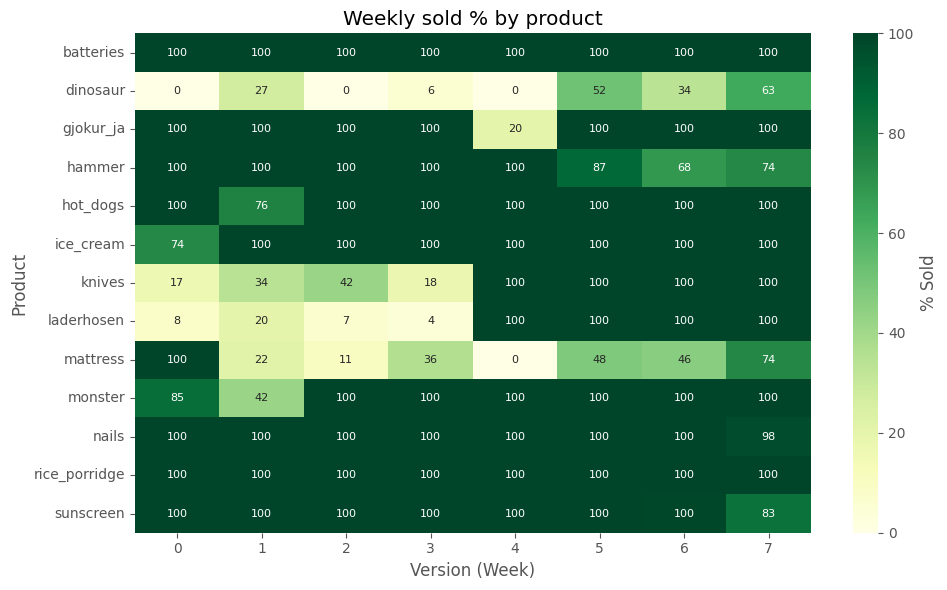

In [10]:
# === Weekly Sold % Heatmap (annotated) ======================================
# Build a weekly sell-through table: (qty sold / amount stocked) per product + version.

# Aggregate sold quantity and total stocked amount per product/version
p = (md.groupby(["product", "version"], as_index=False)
       .agg(qty=("qty", "sum"),
            amount=("amount", "sum")))

# Compute sell-through percentage per product/week
p["sold_pct"] = np.where(p["amount"] > 0, p["qty"] / p["amount"] * 100, 0.0).clip(0, 100)

# Pivot to matrix: rows = product, columns = version (week)
pivot = p.pivot(index="product", columns="version", values="sold_pct").fillna(0.0)

# Draw heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    pivot,
    cmap="YlGn", vmin=0, vmax=100,
    annot=True, fmt=".0f",           # show integer percentages
    annot_kws={"size": 8},
    cbar_kws={"label": "% Sold"}     # colorbar label
)
ax.set_title("Weekly sold % by product")
ax.set_xlabel("Version (Week)")
ax.set_ylabel("Product")
plt.tight_layout()
plt.show()

=== Week 6 Product Summary ===


,product,stock_amount,sold_amount,avg_sold_per_day,sold_out_day
0,batteries,3472,3472.0,496.00,7
1,dinosaur,605,205.0,29.29,-
2,gjokur_ja,94,94.0,13.43,6
3,hammer,4372,2994.0,427.71,-
4,hot_dogs,3239,3239.0,462.71,5
5,ice_cream,3664,3664.0,523.43,7
6,knives,1831,1831.0,261.57,7
7,laderhosen,466,466.0,66.57,3
8,mattress,2918,1338.0,191.14,-
9,monster,3582,3582.0,511.71,4


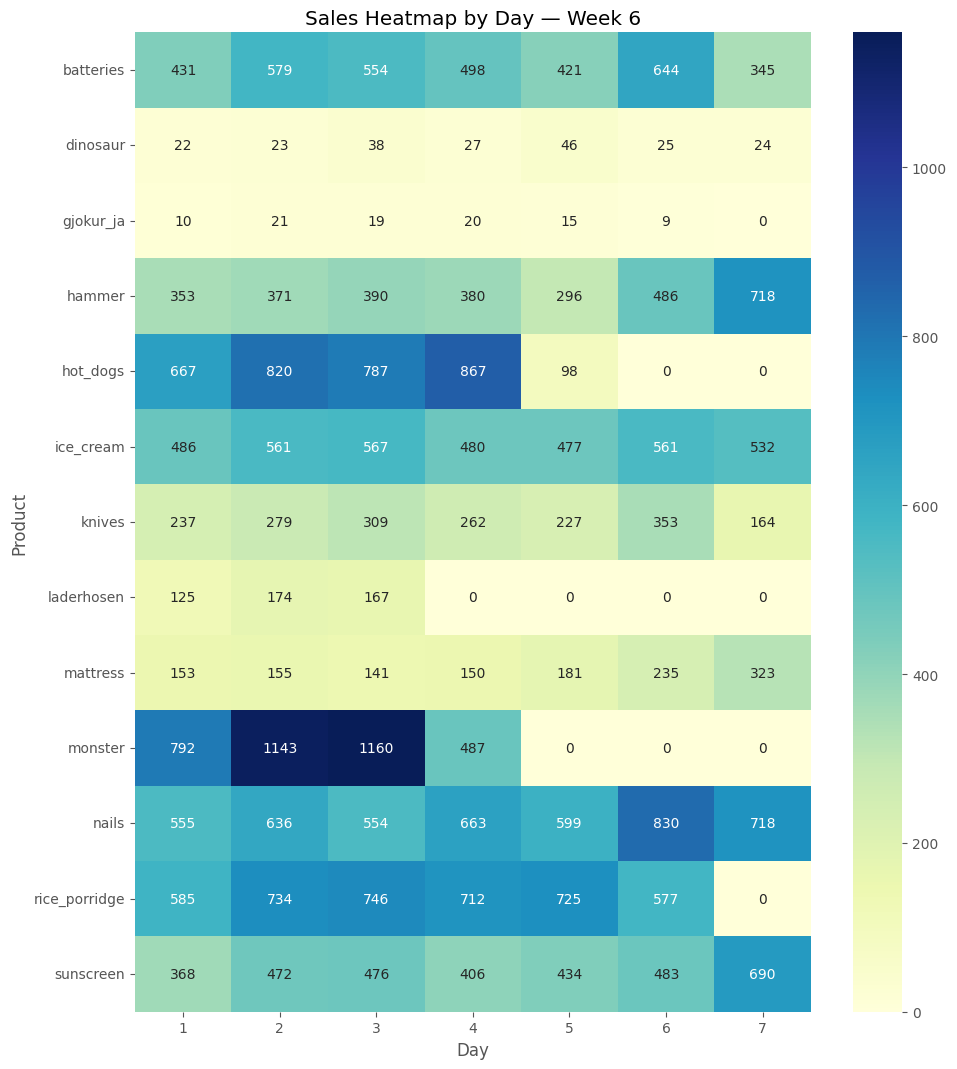

In [11]:
# -----------------------------------------------------------------------------
# Daily Sales Heatmap & Sold-Out Detection (per product, per day)
#
# Description:
#   For the selected week(s), this block:
#     - Aggregates sold quantity per product per day (1–7),
#     - Calculates stats such as average units sold per day and sold-out day,
#     - Displays a per-product summary table,
#     - Generates a heatmap showing daily sales intensity.
#   Darker cells represent higher sales volume, enabling a fast visual detection
#   of products that sell early vs. slowly-moving or dead inventory.
# -----------------------------------------------------------------------------

import seaborn as sns

# Ensure qty column is numeric
transactions["qty"] = pd.to_numeric(transactions["qty"], errors="coerce").fillna(0)

# Choose which week(s) to analyze
selected_weeks = [6]  # change this to your desired week(s)

# Normalize input to a list
if isinstance(selected_weeks, int):
    selected_weeks = [selected_weeks]

for v in selected_weeks:
    # Skip if the week doesn't exist in the dataset
    if v not in VERSIONS:
        print(f"Week {v} not found, skipping...")
        continue

    # Filter transactions to one week
    tx_week = transactions[transactions["version"] == v]
    if tx_week.empty:
        print(f"No transactions for week {v}")
        continue

    # Get amount (initial stock per product) for that week
    amounts_week = products[products["version"] == v][["product","amount"]]

    # Aggregate quantity sold per product per day
    sales_per_day = (
        tx_week.groupby(["product", "day"])["qty"]
        .sum()
        .reset_index()
        .sort_values(["product","day"])
    )

    # Days of operation (fixed to 7)
    total_days = 7

    # Compute a small table summarizing key metrics (avg / sold-out day detection)
    summary_rows = []
    for product, grp in sales_per_day.groupby("product"):

        # Build full 1–7 day matrix (to fill missing sale days with zero)
        all_days = pd.DataFrame({"day": range(1, total_days + 1)})
        merged = all_days.merge(grp, on="day", how="left").fillna({"qty": 0})

        # Average daily sales (including zeros on days without sales)
        avg_sold = merged["qty"].sum() / len(merged)

        # Retrieve initial stock amount
        stock_amount = amounts_week.loc[
            amounts_week["product"] == product, "amount"
        ].values[0]

        # Sum sold quantity across the week
        sold_amount = merged["qty"].sum()

        # Latest day where a sale happened
        last_sale_day = grp["day"].max() if sold_amount > 0 else 0

        # Determine if/when product was completely sold out
        sold_out_day = last_sale_day if sold_amount >= stock_amount else "-"

        summary_rows.append({
            "product": product,
            "stock_amount": stock_amount,
            "sold_amount": sold_amount,
            "avg_sold_per_day": round(avg_sold,2),
            "sold_out_day": sold_out_day
        })

    # Convert summary to DataFrame and show it
    week_summary_df = pd.DataFrame(summary_rows)
    print(f"=== Week {v} Product Summary ===")
    display(week_summary_df)

    # Build a heatmap-friendly matrix (product × day → qty)
    heatmap_data = (
        sales_per_day
        .pivot(index="product", columns="day", values="qty")
        .reindex(columns=range(1,8), fill_value=0)
        .fillna(0)
        .astype(int)
    )

    # Plot heatmap of sales per day for this week
    plt.figure(figsize=(10, len(heatmap_data)*0.6 + 3))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f"Sales Heatmap by Day — Week {v}")
    plt.xlabel("Day")
    plt.ylabel("Product")
    plt.tight_layout()
    plt.show()

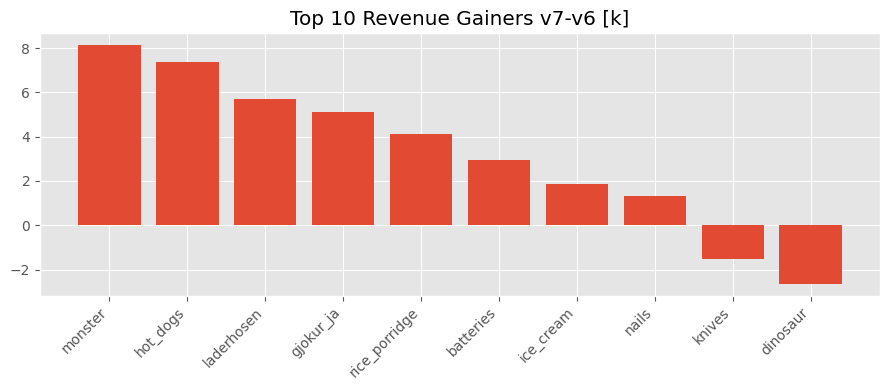

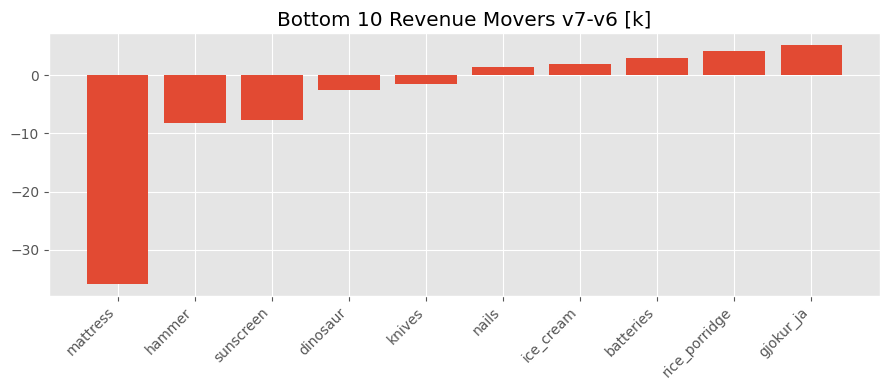

In [12]:
# -----------------------------------------------------------------------------
# Revenue Change Analysis (Version-to-Version Delta)
#
# Description:
#   Compares each product’s revenue between the previous week (V_PREV) and the
#   current week (V_NOW). Computes the revenue delta per product and visualizes:
#     • Top N products with the highest positive revenue change (gainers)
#     • Top N products with the highest negative revenue change (decliners)
#   Useful for identifying which pricing/stock decisions drove revenue movement.
# -----------------------------------------------------------------------------

keep = ["product","amount","price","qty","revenue","gross_profit","supplier_price"]

# Aggregate product-level metrics for previous and current version
prev = md[md["version"] == V_PREV][keep].groupby("product", as_index=False).sum()
now  = md[md["version"] == V_NOW][keep].groupby("product", as_index=False).sum()

# Join weeks side-by-side, calculate revenue delta
cmp = now.merge(prev, on="product", suffixes=("_now","_prev"), how="outer").fillna(0.0)
cmp["revenue_delta"] = cmp["revenue_now"] - cmp["revenue_prev"]

# Select top positive and negative movers
topN = 10
pos = cmp.sort_values("revenue_delta", ascending=False).head(topN)
neg = cmp.sort_values("revenue_delta", ascending=True).head(topN)

# Plot top revenue gainers
plt.figure(figsize=(9,4))
plt.bar(pos["product"], pos["revenue_delta"]/1000)
plt.title(f"Top {topN} Revenue Gainers v{V_NOW}-v{V_PREV} [k]")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot biggest revenue decliners
plt.figure(figsize=(9,4))
plt.bar(neg["product"], neg["revenue_delta"]/1000)
plt.title(f"Bottom {topN} Revenue Movers v{V_NOW}-v{V_PREV} [k]")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()